# LSTM을 활용한 주가 예측 모델

구글 드라이브랑 colab을 연동해줌

colab에 파일 올려두고 이따 가져올 예정이니 꼭 필요함

In [149]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 필요한 모듈 import

In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

구글 드라이브에 데이터셋 파일 (csv파일) 올려두고 

colab 왼쪽에 파일 버튼 눌러서 파일 찾은 다음에

파일 오른쫀 마우스 클릭해서 경로복사, 붙여넣기

In [152]:
import pandas as pd
stock = pd.read_csv('/content/drive/MyDrive/kaggle/나의음식dataset.csv')

In [153]:
stock.head()
# 파일 요약 

,Date,ENERGY,WATER,PROTEIN,FAT,TANSUHWAMUL,CHONGDANGLYU,Health
0,2023-02-02,158,63.00,3.60,3.20,28.80,0.00,0.068122
1,2023-02-03,158,63.00,3.60,3.20,28.80,0.00,0.136243
2,2023-02-04,127,70.40,28.09,0.93,0.00,0.00,0.191732
3,2023-02-05,151,62.90,3.80,1.70,30.20,0.00,0.257921
4,2023-02-06,153,73.42,0.95,9.91,14.89,12.19,0.318329


## 시각화

내 데이터가 건강정도를 기준으로 어떻게 분포가 되어있나

하루마다 음식이 점점 쌓이며 건강정도가 올라갔다가 다음날이 되어서 초기화 되는 형태

건강 정도는 0~1 사이의 값을 가짐

Text(0, 0.5, 'price')

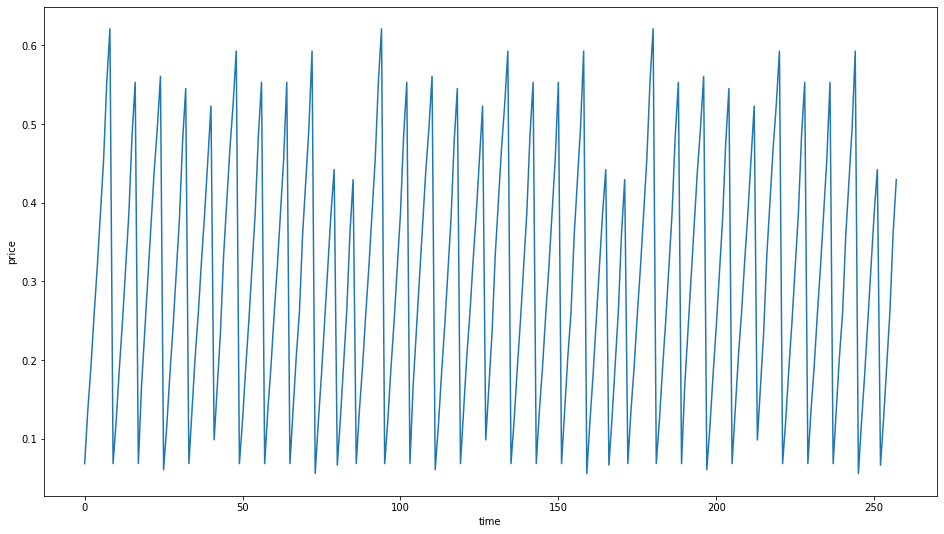

In [155]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Health'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

## 데이터 전처리

데이터의 크기가 각각 다르기 때문에 정규화라는 작업을 해줍니다

0~1사이의 값으로 모든 데이터 값을 비율로 바꿔줌

In [179]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['ENERGY', 'PROTEIN', 'TANSUHWAMUL', 'Health']
# 위 column값들은 각각 에너지, 단백질, 탄수화물, 건강 4개의 컬럼 데이터를 가져와 사용
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.29245283, 0.09764186, 0.94736842, 0.02234047],
       [0.29245283, 0.09764186, 0.94736842, 0.14280562],
       [0.        , 1.        , 0.        , 0.24093032],
       ...,
       [0.29245283, 0.09764186, 0.94736842, 0.36667848],
       [1.        , 0.38135593, 1.        , 0.54047984],
       [0.29245283, 0.09764186, 0.94736842, 0.66094499]])

데이터셋을 판다스의 데이터프레임으로 변환후 df변수에 저장

In [180]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

훈련 용 데이터랑

테스트 용 데이터를 분리시켜줘야 함

In [181]:
from sklearn.model_selection import train_test_split

In [182]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Health', 1), df['Health'], test_size=0.2, random_state=0, shuffle=False)

훈련용 train의 경우 206개의 데이터가 존재하며 에너지, 단백질, 탄수화물 3개로 구성됨

In [183]:
x_train.shape, y_train.shape

((206, 3), (206,))

test 데이터는 훈련 데이터와 형태가 같지만 개수가 훨씬 적음

In [184]:
x_test.shape, y_test.shape

((52, 3), (52,))

훈련 데이터는 이렇게 되어있다 확인

In [185]:
x_train

,ENERGY,PROTEIN,TANSUHWAMUL
0,0.292453,0.097642,0.947368
1,0.292453,0.097642,0.947368
2,0.000000,1.000000,0.000000
3,0.226415,0.105011,0.993421
4,0.245283,0.000000,0.489803
...,...,...,...
201,0.292453,0.097642,0.947368
202,0.292453,0.097642,0.947368
203,1.000000,0.381356,1.000000
204,0.292453,0.097642,0.947368


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

이 과정은 이해 안하고 넘어가도 됨 

우리가 다룰 데이터가 시계열 데이터로 시간이 포함되어 있어서 이를 고려하여 만들어준 함수임

In [166]:
import tensorflow as tf

In [167]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

batch_size는 한번의 훈련에 얼만큼 데이터를 나눠 훈련시킬것이냐 라는 것

In [168]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [169]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [170]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

tensorflow 모델을 사용

LSTM 모델을 사용하였고, 내가 좀 바꾸긴함 우리 음식 데이터에 맞게 하려면 모델 층을 좀 깊게 해야해서 Dense라는 층을 더 추가해줌

이하 모델을 위한 파라미터 설정들임

In [196]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=4,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(64, activation='tanh'),
    Dense(64, activation="ELU"),
    Dense(32, activation="ELU"),
    Dense(16, activation="ELU"),
    Dense(1, activation="sigmoid"),
])

In [197]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [198]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

모델을 구성했으면 이제 model.fit함수로 모델을 훈련시키자

epochs 는 훈련 횟수이며 나머지는 건들필요 없다

훈련 횟수 크게해도 오차정도가 변하지 않으면 알아서 모델은 멈출거임

In [204]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=509, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/509
      5/Unknown - 0s 16ms/step - loss: 0.0114 - mse: 0.0229
Epoch 1: val_loss improved from 0.01264 to 0.01243, saving model to tmp/ckeckpointer.ckpt
6/6 [==============================] - 0s 42ms/step - loss: 0.0138 - mse: 0.0276 - val_loss: 0.0124 - val_mse: 0.0249
Epoch 2/509
6/6 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0266
Epoch 2: val_loss did not improve from 0.01243
6/6 [==============================] - 0s 17ms/step - loss: 0.0133 - mse: 0.0266 - val_loss: 0.0124 - val_mse: 0.0249
Epoch 3/509
1/6 [====>.........................] - ETA: 0s - loss: 0.0076 - mse: 0.0153
Epoch 3: val_loss did not improve from 0.01243
6/6 [==============================] - 0s 14ms/step - loss: 0.0129 - mse: 0.0258 - val_loss: 0.0131 - val_mse: 0.0262
Epoch 4/509
1/6 [====>.........................] - ETA: 0s - loss: 0.0137 - mse: 0.0273
Epoch 4: val_loss did not improve from 0.01243
6/6 [==============================] - 0s 15ms/step - loss: 0.0126 - mse: 0.025

저장한 ModelCheckpoint 를 로드합니다.

In [200]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [201]:
pred = model.predict(test_data)

1/1 [==============================] - 0s 340ms/step


In [202]:
pred.shape

(32, 1)

## 예측 데이터 시각화

이 내용은 앞으로 바꿀 내용인데 그러려니 하고 넘어가자

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

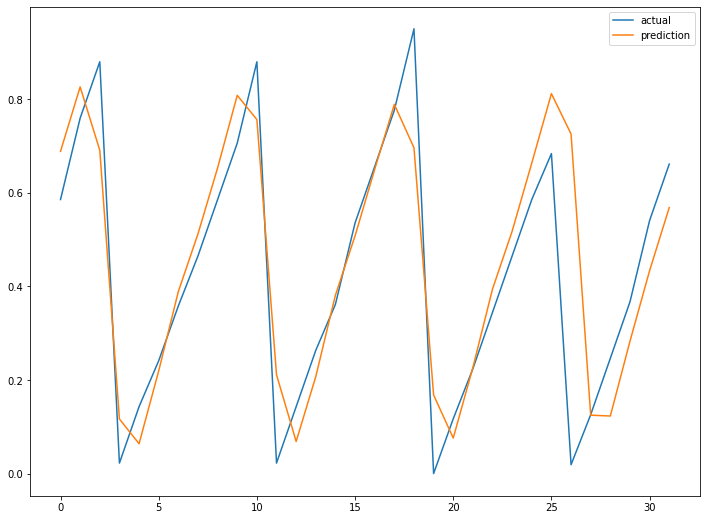

In [208]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()